In [91]:
"""
A Script that plots the proportions of labeled class behaviors that fall within a certain magnitude.
The goal of this experiment is to determine if there is some more
"""

import torch
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from data.swarmset import ContinuingDataset, SwarmDataset
from networks.embedding import NoveltyEmbedding
from networks.archive import DataAggregationArchive
from networks.ensemble import Ensemble
import numpy as np
from scipy import ndimage
import random
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

def CSVLineToVec(line):
    line_list = line.strip().replace("\n", "").split(",")
    float_list = []
    for i in line_list:
        float_list.append(float(i))
    float_list = np.array(float_list)
    return float_list

def getScore(controller):
    v0_l, v0_r = controller[0], controller[1]
    v1_l, v1_r = controller[2], controller[3]
    v0_l, v0_r, v1_l, v1_r = round(v0_l, 1), round(v0_r, 1), round(v1_l, 1), round(v1_r, 1)

    k = 0.5
    max_elem_score = max(-min(controller), max(controller))
    max_elem_score = -max_elem_score if max_elem_score < k else max_elem_score

    k_2 = 0.75
    magnitude_score = np.linalg.norm(controller)
    magnitude_score = -magnitude_score if magnitude_score < k_2 else magnitude_score

    k_3 = 0.3
    average_score = np.average(np.sqrt(np.power(controller, 2)))
    average_score = -average_score if average_score < k_3 else average_score

    # Sensor off magnitude (trial i)
    on_magnitude = (v0_l**2) + (v0_r**2)

    # Sensor on magnitude (trial i)
    off_magnitude = (v1_l**2) + (v1_r**2)

    # Spinning Detection (sensor off - trial ii)
    if v0_l == 0.0 and v0_r == 0.0:
        off_spin_variance = 1
    else:
        denom = v0_l if v0_l != 0.0 else v0_r
        off_spin_variance = min(abs((v0_l + v0_r) / denom), 1.0)
    # mx = off_spin_variance

    # Spinning Detection (sensor on - trial ii)
    if v1_l == 0.0 and v1_r == 0.0:
        on_spin_variance = 0.0
    else:
        denom = v1_l if v1_l != 0.0 else v1_r
        on_spin_variance = min(abs((v1_l + v1_r) / denom), 1)
    # mx = on_spin_variance

    # Mirror Property
    mirrored_controller = np.array([v0_l, v0_r, -v0_l, -v0_r])
    mirror_score = np.linalg.norm(mirrored_controller - controller)
    k_m = 0.3
    mirror_score = -1 if mirror_score < k_m else mirror_score

    # Independence Property
    independent_controller = np.array([v0_l, v0_r, v0_l, v0_r])
    indep = np.linalg.norm(independent_controller - controller)

    # mx = indep + mirror_score + 2*on_spin_variance + 2*off_spin_variance + on_magnitude + off_magnitude + max_elem_score + magnitude_score + average_score
    attributes = [
        indep,
        mirror_score ,
        on_spin_variance,
        off_spin_variance,
        on_magnitude,
        off_magnitude,
        max_elem_score,
        magnitude_score,
        average_score,
    ]

    # Final-2 : includes hand-defined penalties for max_elem, magnitude_score, and average_score
    # weights = [3.8005,  3.1230,  2.1501,  1.3603, -2.7499, -2.7087, -1.8457,  0.1532, 8.1944]

    # 33.8% - 3.5%
    weights = [5.3943,  4.5802,  3.3803,  1.7969, -4.1899, -3.9899, -7.3916,  2.5855, 10.1178]

    # 26% - 2%
    # weights = [4.0272,  3.5402,  2.4813,  1.3740, -1.0721, -1.1566, -6.2047, -0.2631, 4.4113]

    # 19% - 0.5%
    # weights = [0.8481,  0.7023,  1.2814,  0.5064,  0.1424,  0.1305, -0.2721,  0.0841, 1.3685]

    mx = np.dot(np.array(attributes), np.array(weights))
    return mx

rand_count, other_count = 0, 0
small_space = np.linspace(-1.0, 1.0, 21)
print(small_space)
for i in small_space:
    for j in small_space:
        for k in small_space:
            for l in small_space:
                controller = np.array([i, j, k, l])
                score = getScore(controller)
                if score < 10.5:
                    rand_count += 1
                else:
                    other_count += 1
        print(f"Finished Section of k: {controller}")

print(f"RANDOM: {rand_count}, OTHER: {other_count}")

[-1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3
  0.4  0.5  0.6  0.7  0.8  0.9  1. ]
Finished Section of k: [-1. -1.  1.  1.]
Finished Section of k: [-1.  -0.9  1.   1. ]
Finished Section of k: [-1.  -0.8  1.   1. ]
Finished Section of k: [-1.  -0.7  1.   1. ]
Finished Section of k: [-1.  -0.6  1.   1. ]
Finished Section of k: [-1.  -0.5  1.   1. ]
Finished Section of k: [-1.  -0.4  1.   1. ]
Finished Section of k: [-1.  -0.3  1.   1. ]
Finished Section of k: [-1.  -0.2  1.   1. ]
Finished Section of k: [-1.  -0.1  1.   1. ]
Finished Section of k: [-1.  0.  1.  1.]
Finished Section of k: [-1.   0.1  1.   1. ]
Finished Section of k: [-1.   0.2  1.   1. ]
Finished Section of k: [-1.   0.3  1.   1. ]
Finished Section of k: [-1.   0.4  1.   1. ]
Finished Section of k: [-1.   0.5  1.   1. ]
Finished Section of k: [-1.   0.6  1.   1. ]
Finished Section of k: [-1.   0.7  1.   1. ]
Finished Section of k: [-1.   0.8  1.   1. ]
Finished Section of k: [-1.   0.9  1.   1. ]


In [72]:
from sklearn.manifold import TSNE
controllers = []
binary_scores = []
scores = []

N = 12
small_space = np.linspace(-1.0, 1.0, N)
print(small_space)
for i in small_space:
    for j in small_space:
        for k in small_space:
            for l in small_space:
                controller = np.array([i, j, k, l])
                score = getScore(controller)
                if score < 10.5:
                    rand_count += 1
                    binary_scores.append(-1)
                else:
                    binary_scores.append(1)

                controllers.append(controller)
                scores.append(score)

print("Commence T-SNE")
controllers = np.array(controllers)
reduced = TSNE(
    n_components=2,
    learning_rate="auto",
    init="pca",
    perplexity=25,
    early_exaggeration=1
).fit_transform(controllers)


[-1.         -0.81818182 -0.63636364 -0.45454545 -0.27272727 -0.09090909
  0.09090909  0.27272727  0.45454545  0.63636364  0.81818182  1.        ]
Commence T-SNE


/home/connor/Desktop/research/SwarmNoveltyNetwork/.env/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


In [92]:
getScore([0.9, 1.0, -0.9, -1.0])

7.445698081434325

/tmp/ipykernel_2342075/3601943333.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


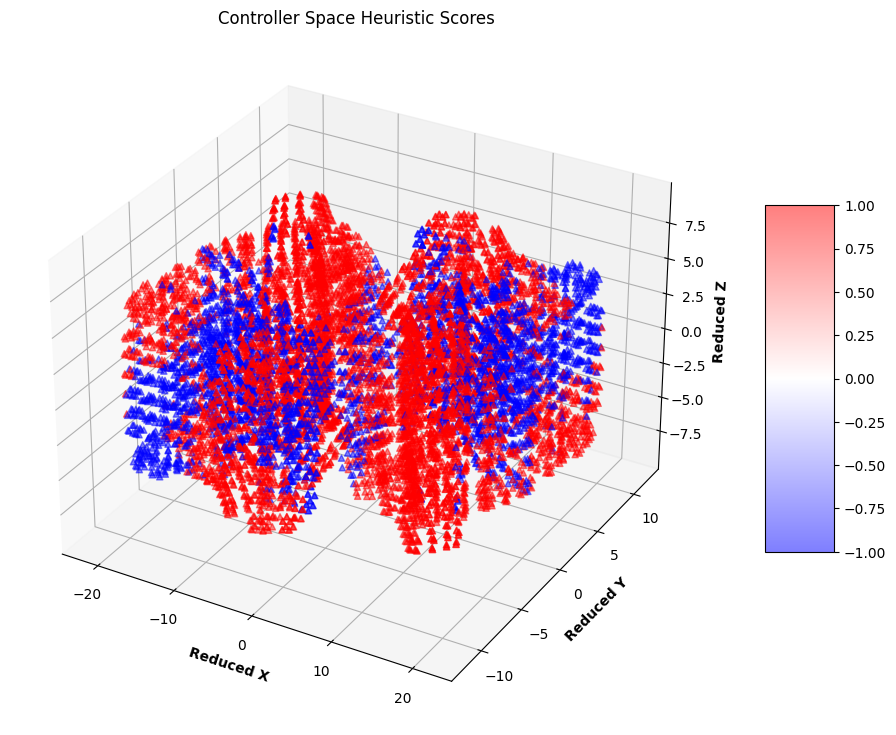

In [24]:
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('bwr')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

sctt = ax.scatter3D(reduced[:,0],reduced[:,1],reduced[:,2],alpha=0.5,c=scores,cmap = my_cmap,marker="^")
ax.set_title("Controller Space Heuristic Scores")
ax.set_xlabel('Reduced X', fontweight ='bold')
ax.set_ylabel('Reduced Y', fontweight ='bold')
ax.set_zlabel('Reduced Z', fontweight ='bold')


fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

/tmp/ipykernel_2342075/103302929.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color ='grey',


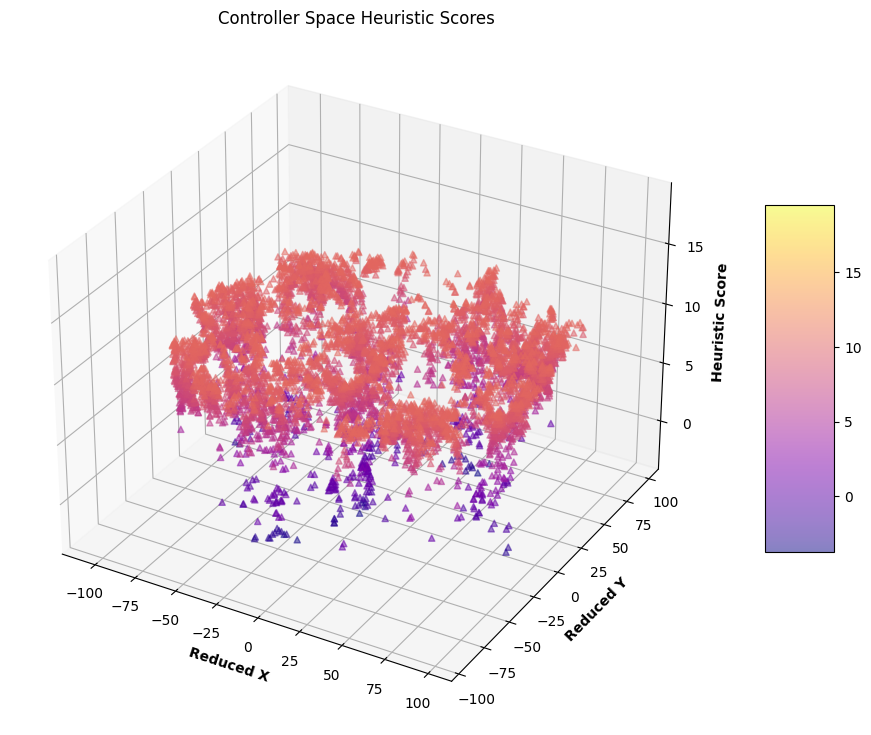

In [89]:
from matplotlib.colors import LightSource
# Hill Shaded Version
fig = plt.figure(figsize = (16, 9))
ax = plt.axes(projection ="3d")
my_cmap = plt.get_cmap('plasma')

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.3,
        alpha = 0.2)

scores = np.array(scores)
ax.set_zlim(min(scores), max(scores))
# sctt = ax.scatter3D(reduced[:,0],reduced[:,1],scores,alpha=0.5,c=scores,cmap = my_cmap,marker="^", vmax=max(scores), vmin=min(scores))
sctt = ax.scatter3D(reduced[np.where(scores < 10.5),0],reduced[np.where(scores < 10.5),1], scores[np.where(scores < 10.5)],alpha=0.5,c=scores[np.where(scores < 10.5)],cmap = my_cmap,marker="^", vmax=max(scores), vmin=min(scores),)
ax.set_title("Controller Space Heuristic Scores")
ax.set_xlabel('Reduced X', fontweight ='bold')
ax.set_ylabel('Reduced Y', fontweight ='bold')
ax.set_zlabel('Heuristic Score', fontweight ='bold')


fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()

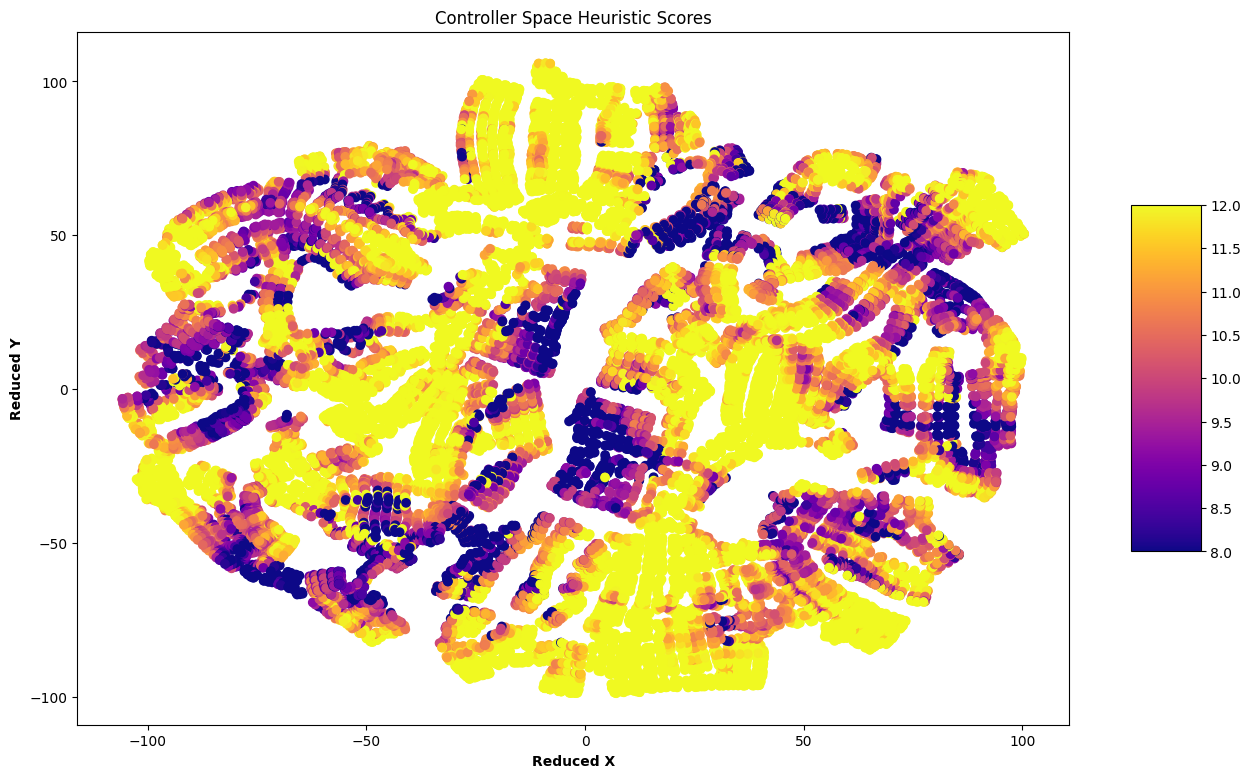

In [83]:
from scipy.interpolate import griddata
clipped_scores = np.clip(scores, 8, 12)
fig = plt.figure(figsize = (16, 9))
ax = plt.axes()
my_cmap = plt.get_cmap('plasma')

sctt = ax.scatter(reduced[:,0],reduced[:,1],c=clipped_scores, cmap=my_cmap)
ax.set_title("Controller Space Heuristic Scores")
ax.set_xlabel('Reduced X', fontweight ='bold')
ax.set_ylabel('Reduced Y', fontweight ='bold')

fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
plt.show()